# Ripple phase modulation

In [10]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
import glob as glob
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
import itertools
from scipy import stats

In [5]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def get_phase_amp_freq(sig,fs):
    
    phas = []
    amp = []
    freq = []
    
    for signal in sig.T:
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        phase = np.angle(analytic_signal)
        instantaneous_phase = np.unwrap(phase)
        instantaneous_frequency = gaussian_filter1d((np.diff(instantaneous_phase) / (2.0*np.pi) * fs),
                                                    0.004 * fs, truncate=8, axis=0,mode='constant')
        phas.append(phase)
        amp.append(amplitude_envelope)
        freq.append(instantaneous_frequency)
    
    phas = np.vstack(phas) 
    amp = np.vstack(amp)
    freq = np.vstack(freq) 
    return phas.T,amp.T,freq.T

## Load data

In [27]:
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
save_path = "F:/Projects/PAE_PlaceCell/ripple_modulation_phase/"
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\cell_recruitment\processed\pyr_int_df.csv')
# df_swr

# with open('F:/Projects/PAE_PlaceCell/swr_data/post_processed/swr_df_maps.pkl', 'rb') as f:
#     df = pickle.load(f)
#     ripple_map = pickle.load(f)
#     filtered_map = pickle.load(f)
#     phase_map = pickle.load(f)
#     amp_map = pickle.load(f)
#     freq_map = pickle.load(f)
    

df = pd.read_csv(r'F:/Projects/PAE_PlaceCell/swr_data/post_processed/swr_df.csv')
df

,Unnamed: 0,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,rat,group,ep_type
0,0,0,66.2624,66.3792,0.1168,0.997065,66.3112,3,6.221621,174.029756,0.000000,LEM3116_S20180715121821,LEM3116,control,track
1,1,1,149.9824,150.1512,0.1688,0.989532,150.1128,1,6.893002,217.563367,0.006667,LEM3116_S20180715121821,LEM3116,control,track
2,2,2,343.5024,343.5952,0.0928,0.995268,343.5472,3,7.195949,212.566470,0.000000,LEM3116_S20180715121821,LEM3116,control,track
3,3,3,344.2784,344.4000,0.1216,0.988154,344.3720,3,5.758124,230.841531,0.000000,LEM3116_S20180715121821,LEM3116,control,track
4,4,4,441.4600,441.6208,0.1608,0.986499,441.5536,4,5.181640,158.973213,0.000000,LEM3116_S20180715121821,LEM3116,control,track
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52602,52602,52602,115.8936,116.0488,0.1552,0.445488,115.9440,4,5.989715,209.285805,0.000000,RH16_S20161207130000,RH16,pae,track
52603,52603,52603,769.6008,769.6736,0.0728,0.170989,769.6200,2,7.993862,192.961786,0.006667,RH16_S20161207130000,RH16,pae,track
52604,52604,52604,1106.5360,1106.6128,0.0768,0.118062,1106.5720,2,9.221199,205.013810,0.000000,RH16_S20161207130000,RH16,pae,track
52605,52605,52605,1189.0416,1189.2408,0.1992,0.142649,1189.1168,2,7.268366,205.098888,0.013333,RH16_S20161207130000,RH16,pae,track


In [ ]:
# loop though sessions

def main(session,df,data_path,savepath,bins=60):
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'

    # check if saved file exists
    if os.path.exists(save_file):
        return

    path = get_session_path(data_path+session+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs)
    # get phase
    phas, _, _ = get_phase_amp_freq(lfp,fs)
    
    # load spikes
    spikes = get_spikes(data_path+session+'.mat')
    
    bins = np.arange(-np.pi,np.pi,2*np.pi/bins)
    # loop through spikes
    spk_phase_all = []
    binned_phase = []
    fitted_phase = []
    peak_phase = []
    for spk in spikes:
        spk_phase = []
        for ripple in df[df.session == session].itertuples():
            # restrict spikes to current ripple
            current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
            # collect interp phase for each spike
            spk_phase.append(np.interp(current_spikes,ts,phas[:,int(ripple.peak_channel)]))
        # flatten phases into nice list    
        x = list(itertools.chain(*spk_phase))    
        # bin from -pi to pi
        y, bin_edges = np.histogram(x,bins=bins)
        # fit data to vonmises
        try:
            kappa, loc, scale = stats.vonmises.fit(x, fscale=1)
            # create vonmises pdf 
            r = stats.vonmises.pdf(bins,kappa=kappa, loc=loc, scale=scale)
            # find peak phase 
            max_phase = bins[np.argmax(r)]
        except ValueError:
            r = []
            max_phase = []
        # append for each cell
        spk_phase_all.append(x)
        binned_phase.append(y)
        fitted_phase.append(r)
        peak_phase.append(max_phase)
        
    # save all cells in a session to file    
    with open(save_file, 'wb') as f:
        pickle.dump(spk_phase_all, f)
        pickle.dump(binned_phase, f)  
        pickle.dump(fitted_phase, f)  
        pickle.dump(peak_phase, f)
            

sessions = pd.unique(df.session)
# for session in sessions:
#     main(session,df,data_path,save_path)
    
num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main)(session,df,data_path,save_path) for session in sessions)


D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


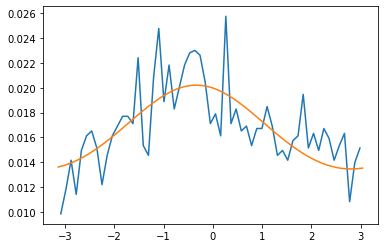

In [125]:
from scipy import stats

binsize = 2*np.pi / 60
bins = np.arange(-np.pi,np.pi,binsize)
bin_centers = np.arange(-np.pi+binsize/2, np.pi -binsize,binsize)

x = list(itertools.chain(*spk_phase_all[5]))

y, bin_edges= np.histogram(x,bins=bins)
y = y / y.sum()
plt.plot(bin_centers,y)

kappa, loc, scale = stats.vonmises.fit(x, fscale=1)
r = stats.vonmises.pdf(bins,kappa=kappa, loc=loc, scale=scale)
r = r/r.sum()
plt.plot(bins,r)

# mu, sigma = stats.norm.fit(x)
# best_fit_line = stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line)

# plt.show()
# list(itertools.chain(*spk_phase_all[2]))
# x